In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import wandb
from sklearn.metrics import f1_score
# from resnet1d import ResNet1D
import pickle

# laveling

In [ ]:
bp_data = np.load('../../data/processed/BP_npy/PulseDB/train_sbp_4.npy')

# ラベリング関数の定義
def label_blood_pressure(bp):
    if bp <= 100:
        return 0    # 正常血圧
    elif 100 < bp < 120:
        return 1    # 正常血圧
    elif 120 <= bp < 140:
        return 2    # 正常高値血圧
    else:
        return 3    # 高血圧

# ベクトル化した関数を作成
vectorized_label = np.vectorize(label_blood_pressure)

# データ全体にラベリングを適用
bp_labels = vectorized_label(bp_data)

In [30]:
def add_bp_class(df, sbp_col="sbp", dbp_col="dbp", new_col="bp_class"):
    """
    Add blood pressure class column based on SBP and DBP values.
    
    Categories:
        0: sbp < 120 and dbp < 80
        1: 120 <= sbp < 140 or 80 <= dbp < 90
        2: sbp >= 140 or dbp >= 90
    """
    
    conditions = [
        (df[sbp_col] < 120) & (df[dbp_col] < 80),
        ((df[sbp_col] >= 120) & (df[sbp_col] < 140)) | ((df[dbp_col] >= 80) & (df[dbp_col] < 90)),
        (df[sbp_col] >= 140) | (df[dbp_col] >= 90)
    ]
    
    values = [0, 1, 2]
    
    df[new_col] = np.select(conditions, values, default=np.nan).astype(int)
    return df

In [33]:
def add_bp(arr,arr2):
    """
    Add blood pressure class column based on SBP and DBP values.
    
    Categories:
        0: sbp < 120 and dbp < 80
        1: 120 <= sbp < 140 or 80 <= dbp < 90
        2: sbp >= 140 or dbp >= 90
    """
    
    conditions = [
        (arr < 120) & (arr2 < 80),
        ((arr >= 120) & (arr < 140)) | ((arr2 >= 80) & (arr2 < 90)),
        (arr >= 140) | (arr2 >= 90)
    ]
    
    values = [0, 1, 2]
    
    class_arr = np.select(conditions, values)
    return class_arr


In [32]:
import      pandas as pd
q  =pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled\test_features.parquet')
q = add_bp_class(q, sbp_col="sbp", dbp_col="dbp", new_col="bp_class")
q['bp_class'].value_counts()

bp_class
0    26326
1    17895
2    10671
Name: count, dtype: int64

(array([1.7000e+01, 4.3900e+02, 1.8209e+04, 4.7756e+04, 3.3236e+04,
        1.0214e+04, 1.6590e+03, 5.7000e+01, 1.1000e+01, 2.0000e+00]),
 array([ 28.7558563 ,  52.12690368,  75.49795106,  98.86899844,
        122.24004582, 145.6110932 , 168.98214058, 192.35318796,
        215.72423534, 239.09528272, 262.4663301 ]),
 <BarContainer object of 10 artists>)

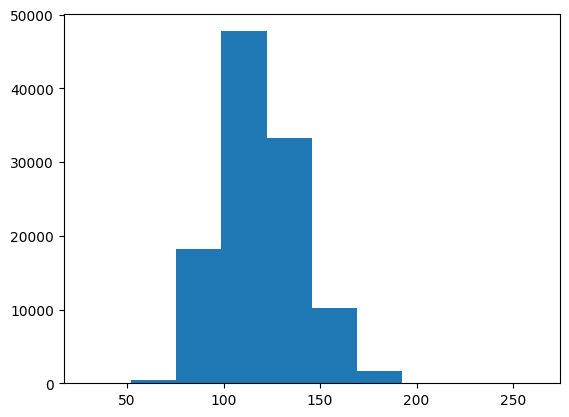

In [29]:
a = np.load('../../data/processed/BP_npy/PulseDB/test_sbp.npy')
import matplotlib.pyplot as plt
plt.hist(a)

In [28]:
test_dataset = BPDataset(train=False, data_dir='../../data/processed/BP_npy/PulseDB',cv=False)
test_dataset.y.unique(return_counts=True)

torch.Size([39361, 1, 1250]) torch.Size([39361])


(tensor([0, 1]), tensor([ 1294, 38067]))

In [27]:
print("ラベルの分布:")
unique, counts = np.unique(bp_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"ラベル {label}: {count}件")

ラベルの分布:
ラベル 0: 171782件
ラベル 3: 140660件


In [28]:
np.save('../../data/processed/BP_npy/PulseDB/test_sbp_4labels.npy', bp_labels)

2値


In [ ]:
labels = add_bp(arr)

In [3]:
# ラベルデータの読み込み
labels = np.load('../../data/processed/BP_npy/PulseDB/test_sbp_4labels.npy')

# ラベルが0または3のインデックスを抽出
mask = (labels == 0) | (labels == 3)
selected_indices = np.where(mask)[0]

# 対応するデータの抽出
original_data = np.load('../../data/processed/BP_npy/PulseDB/test.npy')
filtered_data = original_data[selected_indices]
filtered_labels = labels[selected_indices]
filtered_labels[filtered_labels==3]=1
# 確認
print(f"元のデータ数: {len(labels)}")
print(f"フィルタ後のデータ数: {len(filtered_labels)}")
print("ラベルの分布:")
unique, counts = np.unique(filtered_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"ラベル {label}: {count}件")

# 必要に応じて新しいファイルとして保存
np.save('../../data/processed/BP_npy/PulseDB/test_2.npy', filtered_data)
np.save('../../data/processed/BP_npy/PulseDB/test_sbp_2labels.npy', filtered_labels)

元のデータ数: 111600
フィルタ後のデータ数: 38110
ラベルの分布:
ラベル 0: 20674件
ラベル 1: 17436件


## cv
cv[0][:5] : train  
cv[1][:5] : val

In [4]:
cv_idx_path = r"../../data/processed/BP_npy/PulseDB/cv_5fold.pkl"
with open(cv_idx_path, "rb") as f:
    cv_idx = pickle.load(f)
labels = np.load('../../data/processed/BP_npy/PulseDB/train_sbp_4labels.npy')
train_sbp = []
val_sbp = []
train_idx = []
val_idx = []
for fold in range(5):
    train_ = labels[cv_idx[0][fold]]
    idx_ = np.where((train_==0)|(train_==3))
    train_idx.append(idx_)
    train_ = train_[idx_]
    # train_[train_==0]=0
    train_[train_==3]=1
    train_sbp.append(train_)
    val_ = labels[cv_idx[1][fold]]
    idx_ = np.where((val_==0)|(val_==3))
    val_idx.append(idx_)
    val_ = val_[idx_]
    # val_[val_==0]=0
    val_[val_==3]=1
    val_sbp.append(val_)
sbp_2labels_cv = [train_sbp,val_sbp]
ppgidx_2labels_cv = [train_idx,val_idx]
with open('../../data/processed/BP_npy/PulseDB/ppgidx_2labels_cv.pkl','wb') as f:
    pickle.dump(ppgidx_2labels_cv,f)
with open('../../data/processed/BP_npy/PulseDB/sbp_2labels_cv.pkl','wb') as f:
    pickle.dump(sbp_2labels_cv,f)
print(labels.shape)

(902160,)


In [5]:
# ラベルデータの読み込み
labels = np.load('../../data/processed/BP_npy/PulseDB/train_sbp_4labels.npy')

# ラベルが0または3のインデックスを抽出
mask = (labels == 0) | (labels == 3)
selected_indices = np.where(mask)[0]

# 対応するデータの抽出
original_data = np.load('../../data/processed/BP_npy/PulseDB/train.npy')
filtered_data = original_data[selected_indices]
filtered_labels = labels[selected_indices]
filtered_labels[filtered_labels==3]=1
# 確認
print(f"元のデータ数: {len(labels)}")
print(f"フィルタ後のデータ数: {len(filtered_labels)}")
print("ラベルの分布:")
unique, counts = np.unique(filtered_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"ラベル {label}: {count}件")

# 必要に応じて新しいファイルとして保存
np.save('../../data/processed/BP_npy/PulseDB/train_2.npy', filtered_data)
np.save('../../data/processed/BP_npy/PulseDB/train_sbp_2labels.npy', filtered_labels)

元のデータ数: 902160
フィルタ後のデータ数: 312442
ラベルの分布:
ラベル 0: 171782件
ラベル 1: 140660件


# laveling retry

In [ ]:
bp_data = np.load('../../data/processed/BP_npy/PulseDB/train_sbp.npy')
print(bp_data.shape)
# ラベリング関数の定義
def label_blood_pressure(bp):
    if bp <= 100:
        return 0    # 正常血圧
    elif 100 < bp < 120:
        return 1    # 正常血圧
    elif 120 < bp < 140:
        return 2    # 正常高値血圧
    else:
        return 3    # 高血圧

# ベクトル化した関数を作成
vectorized_label = np.vectorize(label_blood_pressure)

# データ全体にラベリングを適用
bp_labels = vectorized_label(bp_data)

(902160,)


In [ ]:
# 確認
print(f"元のデータ数: {len(bp_labels)}")
# print(f"フィルタ後のデータ数: {len(filtered_labels)}")
print("ラベルの分布:")
unique, counts = np.unique(bp_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"ラベル {label}: {count}件")

元のデータ数: 902160
ラベルの分布:
ラベル 0: 171782件
ラベル 1: 336150件
ラベル 2: 253568件
ラベル 3: 140660件


In [ ]:
np.save('../../data/processed/BP_npy/PulseDB/train_sbp_labels.npy',bp_labels)

In [6]:
labels = np.load('../../data/processed/BP_npy/PulseDB/train_sbp_labels.npy')

# ラベルが0または3のインデックスを抽出
mask = (labels == 0) | (labels == 3)
selected_indices = np.where(mask)[0]

# 対応するデータの抽出
original_data = np.load('../../data/processed/BP_npy/PulseDB/train_raw.npy')
filtered_data = original_data[selected_indices]
filtered_labels = labels[selected_indices]
filtered_labels[filtered_labels==3]=1
# 確認
print(f"元のデータ数: {len(labels)}")
print(f"フィルタ後のデータ数: {len(filtered_labels)}")
print("ラベルの分布:")
unique, counts = np.unique(filtered_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"ラベル {label}: {count}件")

# 必要に応じて新しいファイルとして保存
np.save('../../data/processed/BP_npy/PulseDB/train_2.npy', filtered_data)
np.save('../../data/processed/BP_npy/PulseDB/train_sbp_2labels.npy', filtered_labels)

元のデータ数: 902160
フィルタ後のデータ数: 312442
ラベルの分布:
ラベル 0: 171782件
ラベル 1: 140660件


## test

In [ ]:
bp_data = np.load('../../data/processed/BP_npy/PulseDB/test_sbp.npy')
vectorized_label = np.vectorize(label_blood_pressure)
# データ全体にラベリングを適用
bp_labels = vectorized_label(bp_data)
# 確認
print(f"元のデータ数: {len(bp_labels)}")
# print(f"フィルタ後のデータ数: {len(filtered_labels)}")
print("ラベルの分布:")
unique, counts = np.unique(bp_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"ラベル {label}: {count}件")

元のデータ数: 111600
ラベルの分布:
ラベル 0: 20674件
ラベル 1: 41043件
ラベル 2: 32447件
ラベル 3: 17436件


In [ ]:
np.save('../../data/processed/BP_npy/PulseDB/test_sbp_labels.npy',bp_labels)

In [ ]:
labels = np.load('../../data/processed/BP_npy/PulseDB/test_sbp_labels.npy')

# ラベルが0または3のインデックスを抽出
mask = (labels == 0) | (labels == 3)
selected_indices = np.where(mask)[0]

# 対応するデータの抽出
original_data = np.load('../../data/processed/BP_npy/PulseDB/test_raw.npy')
filtered_data = original_data[selected_indices]
filtered_labels = labels[selected_indices]
filtered_labels[filtered_labels==3]=1
# 確認
print(f"元のデータ数: {len(labels)}")
print(f"フィルタ後のデータ数: {len(filtered_labels)}")
print("ラベルの分布:")
unique, counts = np.unique(filtered_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"ラベル {label}: {count}件")

# 必要に応じて新しいファイルとして保存
np.save('../../data/processed/BP_npy/PulseDB/test_2.npy', filtered_data)
np.save('../../data/processed/BP_npy/PulseDB/test_sbp_2labels.npy', filtered_labels)

元のデータ数: 111600
フィルタ後のデータ数: 38110
ラベルの分布:
ラベル 0: 20674件
ラベル 1: 17436件


## cv laveling retry

In [ ]:
cv_idx_path = r"../../data/processed/BP_npy/PulseDB/cv_5fold_2labels.pkl"
with open(cv_idx_path, "rb") as f:
    cv_idx = pickle.load(f)
labels = np.load('../../data/processed/BP_npy/PulseDB/train_sbp_2labels.npy')
train_sbp = []
val_sbp = []
train_idx = []
val_idx = []
for fold in range(5):
    train_ = labels[cv_idx[0][fold]]
    idx_ = np.where((train_==0)|(train_==3))
    train_idx.append(idx_)
    train_ = train_[idx_]
    # train_[train_==0]=0
    train_[train_==3]=1
    train_sbp.append(train_)
    val_ = labels[cv_idx[1][fold]]
    idx_ = np.where((val_==0)|(val_==3))
    val_idx.append(idx_)
    val_ = val_[idx_]
    # val_[val_==0]=0
    val_[val_==3]=1
    val_sbp.append(val_)
sbp_2labels_cv = [train_sbp,val_sbp]
ppgidx_2labels_cv = [train_idx,val_idx]
with open('../../data/processed/BP_npy/PulseDB/ppgidx_2labels_cv.pkl','wb') as f:
    pickle.dump(ppgidx_2labels_cv,f)
with open('../../data/processed/BP_npy/PulseDB/sbp_2labels_cv.pkl','wb') as f:
    pickle.dump(sbp_2labels_cv,f)
print(labels.shape)

(902160,)


# Dataset 

In [ ]:
# class BPDataset(Dataset):
#     def __init__(self, data_dir,train=True):
#         # Load data
#         if train:
#             self.x = np.load(f'{data_dir}/train.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
#             self.y = np.load(f'{data_dir}/train_sbp_4labels.npy')  # Shape: (-1,)
#             print(self.x.shape,self.y.shape)
#             # self.x = np.load(f'{data_dir}/train_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
#             # self.y = np.load(f'{data_dir}/train_sbp_2labels.npy')  # Shape: (-1,)
#         else:
#             self.x = np.load(f'{data_dir}/test.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
#             self.y = np.load(f'{data_dir}/test_sbp_4labels.npy')  # Shape: (-1,)
#             # self.x = np.load(f'{data_dir}/test_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
#             # self.y = np.load(f'{data_dir}/test_sbp_2labels.npy')  # Shape: (-1,)
        
#         # Convert to torch tensors
#         self.x = torch.FloatTensor(self.x)
#         self.y = torch.LongTensor(self.y)
#         print(self.x.shape,self.y.shape)
#     def __len__(self):
#         return len(self.y)
    
#     def __getitem__(self, idx):
#         return self.x[idx], self.y[idx]



In [34]:
class BPDataset(Dataset):
    def __init__(self, data_dir,cv=False,fold=None,train=True):
        # Load data
        if train:
            if cv:
                self.x = np.load(f'{data_dir}/train_2.npy')[:, 1, :].reshape(-1,1,1250)
                self.y = np.load(f'{data_dir}/train_sbp_2labels.npy')
                with open(f'{data_dir}/cv_5fold_2labels.pkl','rb') as f:
                    file = pickle.load(f)
                    self.x = self.x[file[0][fold]]
                    self.y = self.y[file[0][fold]]
                # with open(f'{data_dir}/ppgidx_2labels_cv.pkl','rb') as f:
                #     ppgidx_2labels_cv = pickle.load(f)
                # self.x = self.x[ppgidx_2labels_cv[0][fold]]
                # with open(f'{data_dir}/sbp_2labels_cv.pkl','rb') as f:
                #     sbp_4labels_cv = pickle.load(f)
            else:
                self.x = np.load(f'{data_dir}/train_4.npy')[:, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
                self.y = np.load(f'{data_dir}/train_sbp.npy') 
                dbp = np.load(f'{data_dir}/train_dbp.npy')
                self.y = add_bp(self.y, dbp)# Shape: (-1,)
                self.x = self.x[self.y!=2]
                self.y = self.y[self.y!=2]
            print(self.x.shape,self.y.shape)
            # self.x = np.load(f'{data_dir}/train_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            # self.y = np.load(f'{data_dir}/train_sbp_2labels.npy')  # Shape: (-1,)
        else:
            if cv:
                self.x = np.load(f'{data_dir}/train_4.npy')[:, 1, :].reshape(-1,1,1250) # Shape: (-1, 1250)
                self.y = np.load(f'{data_dir}/train_sbp.npy')
                with open(f'{data_dir}/cv_5fold_2labels.pkl','rb') as f:
                    file = pickle.load(f)
                    self.x = self.x[file[1][fold]]
                    self.y = self.y[file[1][fold]]
                # with open(f'{data_dir}/ppgidx_2labels_cv.pkl','rb') as f:
                #     ppgidx_2labels_cv = pickle.load(f)
                # self.x = self.x[ppgidx_2labels_cv[1][fold]]
                # with open(f'{data_dir}/sbp_2labels_cv.pkl','rb') as f:
                #     sbp_4labels_cv = pickle.load(f)
                # self.y = sbp_4labels_cv[1][fold]  # Shape: (-1,)
            else:
                self.x = np.load(f'{data_dir}/test_4.npy')[:, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
                self.y = np.load(f'{data_dir}/test_sbp.npy')  # Shape: (-1,)
                dbp = np.load(f'{data_dir}/test_dbp.npy')
                self.y = add_bp(self.y, dbp)
                self.x = self.x[self.y!=2]
                self.y = self.y[self.y!=2]
            # self.x = np.load(f'{data_dir}/test_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            # self.y = np.load(f'{data_dir}/test_sbp_2labels.npy')  # Shape: (-1,)
        # Convert to torch tensors
        self.x = torch.FloatTensor(self.x)
        self.y = torch.LongTensor(self.y)
        print(self.x.shape,self.y.shape)
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
class BPDataset_Regr(Dataset):
    def __init__(self, data_dir,cv=None,train=True):
        # Load data
        if train:
            self.x = np.load(f'{data_dir}/train.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            self.sbp = np.load(f'{data_dir}/train_sbp.npy')  # Shape: (-1,)
            self.dbp = np.load(f'{data_dir}/train_dbp.npy')  # Shape: (-1,)
        else:
            if cv is not None:
                self.x = np.load(f'{data_dir}/train.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
                self.sbp = np.load(f'{data_dir}/train_sbp.npy')  # Shape: (-1,)
                self.dbp = np.load(f'{data_dir}/train_dbp.npy')

            else:
                self.x = np.load(f'{data_dir}/test.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
                self.sbp = np.load(f'{data_dir}/test_sbp.npy')  # Shape: (-1,)
                self.dbp = np.load(f'{data_dir}/test_dbp.npy')  # Shape: (-1,)
        if cv is not None:
            self.x = self.x[cv]
            self.sbp = self.sbp[cv]
            self.dbp = self.dbp[cv]
        scale = np.load(f'{data_dir}/scale_train.npy')
        self.sbp = self.sbp * scale[0,1]- scale[0,0]
        self.dbp = self.dbp * scale[0,1] - scale[0,0]

        # Convert to torch tensors
        self.x = torch.FloatTensor(self.x)
        self.sbp = torch.FloatTensor(self.sbp)
        self.dbp = torch.FloatTensor(self.dbp)
        print(self.x.shape,self.sbp.shape,self.dbp.shape)
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.sbp[idx],self.dbp[idx]


# import and functions

In [11]:

class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, path, patience=5, verbose=False):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        # self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        
        self.path = path             #ベストモデル格納path
        os.makedirs(os.path.dirname(self.path),exist_ok=True)
    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score
            self.checkpoint(score, model)  #記録後にモデルを保存してスコア表示する
        elif score > self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する
                print(f"the best of loss: {self.best_score:.5f}")
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.checkpoint(score, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, score, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.best_score:.5f} --> {score:.5f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.best_score = score #その時のlossを記録する

In [10]:
def output_warning(config):
    # 'output_path'が存在する場合
    if os.path.exists(config["output_path"]):
        # ユーザーに確認を求める（enterを押したらyes）
        confirmation = input(f"Warning: The output path {config['output_path']} already exists. Do you want to continue? Press Enter to continue: ").strip().lower()
        
        # 入力が空（Enter）が押された場合は続行、それ以外はエラー
        if confirmation == "" or confirmation == "y":
            print("Proceeding with the operation...")
        else:
            raise ValueError("Operation aborted by the user.")
    else:
        print(f"The output path {config['output_path']} does not exist. Proceeding...")


In [20]:
def create_figure(gt,pred):
    fig,ax = plt.subplots()
    ax.plot(gt,label="true")  
    ax.plot(gt,label="pred")
    ax.legend()
    return fig
def log_img(gt,pred):
    gt, pred = gt[0].detach().clone().cpu().numpy(), pred[0].detach().clone().cpu().numpy()
    figure = create_figure(gt,pred)
    img = wandb.Image(figure)
    plt.clf()
    plt.close()
    return img
def compute_class_weights(labels):
# クラスごとのサンプル数をカウント
    unique, counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    
    # クラスの重みを計算 (サンプル数の逆数で重み付け)
    weights = total_samples / (len(unique) * counts)
    return torch.FloatTensor(weights)

# モデルの評価指標
def calculate_metrics(y_true, y_pred,classes=2):
    # 正解率
    accuracy = np.mean(y_true == y_pred)
    
    # クラスごとの精度を計算
    class_accuracies = []
    for cls in range(classes):
        mask = (y_true == cls)
        if np.sum(mask) > 0:
            class_acc = np.sum((y_true == y_pred) & mask) / np.sum(mask)
            class_accuracies.append(class_acc)
        else:
            raise ValueError(f"Class {cls} has no samples.")
    
    # マクロ平均F1スコア
    f1_macro = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, class_accuracies, f1_macro

# Training

In [35]:
# データセットとDataLoaderの作成
data_dir = '../../data/processed/BP_npy/PulseDB'
batch_size = 32

train_dataset = BPDataset(data_dir,train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BPDataset(data_dir,train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# トレーニングデータの確認
x, y = train_dataset[0]
print("Training data:")
print(f"x shape: {x.shape}, x dtype: {x.dtype}")
print(f"y shape: {y.shape}, y dtype: {y.dtype}")
print(f"Unique labels in training: {torch.unique(train_dataset.y)}")

# テストデータの確認
x, y = test_dataset[0]
print("\nTest data:")
print(f"x shape: {x.shape}, x dtype: {x.dtype}")
print(f"y shape: {y.shape}, y dtype: {y.dtype}")
print(f"Unique labels in test: {torch.unique(test_dataset.y)}")

(789134, 1, 1250) (789134,)
torch.Size([789134, 1, 1250]) torch.Size([789134])
torch.Size([98148, 1, 1250]) torch.Size([98148])
Training data:
x shape: torch.Size([1, 1250]), x dtype: torch.float32
y shape: torch.Size([]), y dtype: torch.int64
Unique labels in training: tensor([0, 1])

Test data:
x shape: torch.Size([1, 1250]), x dtype: torch.float32
y shape: torch.Size([]), y dtype: torch.int64
Unique labels in test: tensor([0, 1])


In [36]:
test_dataset.y.unique(return_counts=True)

(tensor([0, 1]), tensor([61297, 36851]))

## 分類

In [39]:
# from resnet1d import ResNet1D
from se_resnet1d import resnet18mini2
def train_model(config):
    
    # Initialize Weights & Biases (wandb)
    wandb.init(project="regression-training", config=config)
    config = wandb.config

    # Dataset and DataLoader
    # train_dataset = train_dataset(data_root=r"..\data\processed\BP_npy\250107_1152\p00")
    # train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    train_loader = train_dataloader
    # val_dataset = test_dataset(data_len=-1,data_root=r"..\data\processed\BP_npy\250107_1152\p00")
    # val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    val_loader = test_dataloader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:",device)
    labels = train_dataset.y.numpy()
    class_weights = compute_class_weights(labels)
    print(class_weights)
    class_weights = class_weights.to(device)  # 重みをGPUに移動

    # Model, Loss, and Optimizer
    # model = ResNet1D(**config["network"])
    model = resnet18mini2(num_classes=config["network"]["n_classes"],in_channels=1)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    # criterion = nn.CrossEntropyLoss()
    # mae = nn.L1Loss()  # Mean Squared Error Loss for regression
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    earlystopping = EarlyStopping(f"{config.output_path}/best.pth",config.patience,verbose=True)
    model.to(device)

    wandb.watch(model, log_freq=config.log_interval)
    for epoch in range(config.epochs):
        model.train()
        running_loss = 0.0
        # running_loss_mae = 0.0
        # Training phase with progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{config.epochs} - Training", leave=False)
        for batch_idx, (x,y) in enumerate(train_loader_tqdm):
            x,y = x.to(device), y.to(device)
            # print(gt.shape,cond.shape)
            optimizer.zero_grad()
            outputs = model(x)
            # print(outputs.device,y.device)
            loss = criterion(outputs, y)
            # loss_mae = mae(outputs, gt)
            loss.backward()
            optimizer.step()
            if batch_idx % config.log_interval == 0:
                wandb.log({"train_loss_step": loss.item()})
            # if batch_idx  == 0:
                # wandb.log({"train/loss": log_img(gt,outputs)})
            running_loss += loss.item()
            # running_loss_mae += loss_mae.item()
            train_loader_tqdm.set_postfix(loss=running_loss/(batch_idx+1))

        train_loss = running_loss / len(train_loader)
        # train_loss_mae = running_loss_mae / len(train_loader)

        # Validation phase with progress bar
        model.eval()
        val_loss = 0.0
        all_y_true = []
        all_y_pred = []
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{config.epochs} - Validation", leave=False)
        with torch.no_grad():
            for batch_idx, (x,y) in enumerate(val_loader_tqdm):

                x,y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                # loss_mae = mae(outputs, gt)
                if batch_idx % config.log_interval == 0:
                    wandb.log({"test_loss_step": loss.item()})
                # if batch_idx  == 0:
                #     wandb.log({"val/loss": log_img(gt,outputs)})
                val_loss += loss.item()
                # val_loss_mae += loss_mae.item()
                _, predicted = torch.max(outputs.data, 1)
                all_y_true.extend(y.cpu().numpy())
                all_y_pred.extend(predicted.cpu().numpy())
        all_y_true = np.array(all_y_true)
        all_y_pred = np.array(all_y_pred)
        accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred,classes=config["network"]["n_classes"])
        val_loss = val_loss / len(val_loader)
        # WandBでのログ記録例
        wandb.log({
            "train_loss": train_loss,
            "test_loss": val_loss,
            "accuracy": accuracy.item(),
            "f1_macro": f1,
            "class_0_accuracy": class_accuracies[0].item(),
            "class_1_accuracy": class_accuracies[1].item(),
            # "class_2_accuracy": class_accuracies[2].item(),
            # "class_3_accuracy": class_accuracies[3].item(),
            "conf_mat": wandb.plot.confusion_matrix(y_true=all_y_true, preds=all_y_pred, class_names=["0","1"]),
            "epoch": epoch + 1
        })
        # val_loss_mae /= len(val_loader)
        earlystopping(val_loss,model)
        if earlystopping.early_stop:
            print("Early Stopping!")
            wandb.finish()
            break
        # Log metrics to wandb
        # wandb.log({
        #     "epoch": epoch + 1,
        #     "train/loss_epoch": train_loss,
        #     "train/mae": train_loss_mae,
        #     "val/loss_epoch": val_loss,
        #     "val/mae": val_loss_mae
        # })

        print(f"Epoch [{epoch + 1}/{config.epochs}]"
              f" Train Loss: {train_loss:.4f}"
              f" Val Loss: {val_loss:.4f}")




## cv 

In [9]:
from se_resnet1d import resnet18mini as resnet
from transformers import get_cosine_schedule_with_warmup
def train_model_clf_cv(config,fold=5):
    output_warning(config)
    data_dir = '../../data/processed/BP_npy/PulseDB'
    # Initialize Weights & Biases (wandb)
    wandb.init(project="regression-training", config=config)
    config = wandb.config
    
    for f in range(fold):
        
        train_dataset = BPDataset(data_dir,cv=True,fold=f,train=True)
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

        val_dataset = BPDataset(data_dir,cv=True,fold=f,train=False)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("device:",device)
        unique, counts = np.unique(train_dataset.y, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"ラベル {label}: {count}件")
        unique, counts = np.unique(val_dataset.y, return_counts=True)
        for label, count in zip(unique, counts):
            print(f"ラベル {label}: {count}件")
        # Model, Loss, and Optimizer
        # model = ResNet1D(**config["network"])
        model = resnet(num_classes=config["network"]["n_classes"],in_channels=1)
        # criterion = nn.L1Loss()
        labels = np.load(f'{data_dir}/train_sbp_2labels.npy')
        with open(f"{data_dir}/cv_5fold_2labels.pkl", "rb") as file:
            cv_idx = pickle.load(file) 
            labels = labels[cv_idx[0][f]]
        class_weights = compute_class_weights(labels)
        print(class_weights)
        class_weights = class_weights.to(device)  # 重みをGPUに移動

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        # mae = nn.L1Loss()  # Mean Squared Error Loss for regression
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        total_step_size = len(train_loader) * config.min_epochs
        warmup_steps = int(total_step_size * 0.1)  # 10% of total steps
        lr_scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_step_size)

        earlystopping = EarlyStopping(f"{config.output_path}/best_fold{f}.pth",config.patience,verbose=True)
        model.to(device)

        wandb.watch(model, log_freq=config.log_interval)
        for epoch in range(config.epochs):
            model.train()
            running_loss = 0.0
            # running_loss_mae = 0.0
            # Training phase with progress bar
            train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{config.epochs} - Training", leave=False)
            for batch_idx, (x,y) in enumerate(train_loader_tqdm):
                x,y = x.to(device), y.to(device)
                # print(gt.shape,cond.shape)
                optimizer.zero_grad()
                outputs = model(x)
                # print("Input shape:", x.shape,y.shape,outputs.shape)
                # print("Check for NaN:", torch.isnan(x).any(),torch.isnan(y).any(),torch.isnan(outputs).any())
                # print("Check for Inf:", torch.isinf(x).any(),torch.isinf(y).any(),torch.isinf(outputs).any())
                # print(outputs.device,y.device)
                loss = criterion(outputs, y) 
                # loss_mae = mae(outputs, gt)
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                if batch_idx % config.log_interval == 0:
                    wandb.log({"train_loss_step": loss.item(),
                               "lr": lr_scheduler.get_last_lr()[0]})
                # if batch_idx  == 0:
                    # wandb.log({"train/loss": log_img(gt,outputs)})
                running_loss += loss.item()
                # running_loss_mae += loss_mae.item()
                train_loader_tqdm.set_postfix(loss=running_loss/(batch_idx+1))

            train_loss = running_loss / len(train_loader)
            # train_loss_mae = running_loss_mae / len(train_loader)

            # Validation phase with progress bar
            model.eval()
            val_loss = 0.0
            all_y_true = []
            all_y_pred = []
            val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{config.epochs} - Validation", leave=False)
            with torch.no_grad():
                for batch_idx, (x,y) in enumerate(val_loader_tqdm):

                    x,y = x.to(device), y.to(device)
                    outputs = model(x)
                    # print(outputs.device,y.device)
                    loss = criterion(outputs,y) 
                    # loss_mae = mae(outputs, gt)
                    if batch_idx % config.log_interval == 0:
                        wandb.log({"test_loss_step": loss.item()})
                    # if batch_idx  == 0:
                    #     wandb.log({"val/loss": log_img(gt,outputs)})
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    # val_loss_mae += loss_mae.item()
                    all_y_true.extend(np.array(y.cpu().numpy()))
                    all_y_pred.extend(np.array(predicted.cpu().numpy()))
            all_y_true = np.array(all_y_true)
            all_y_pred = np.array(all_y_pred)
            # print(all_y_true.shape,all_y_pred.shape)
            accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred,classes=config["network"]["n_classes"])
            # error = (all_y_true - all_y_pred)
            # mse = np.mean(error**2,axis=0)
            # rmse = np.sqrt(mse)
            # std = np.std(error,axis=0)
            val_loss = val_loss / len(val_loader)
            # WandBでのログ記録例
            wandb.log({
                "train_loss": train_loss,
                "test_loss": val_loss,
                "accuracy": accuracy.item(),
                "f1_macro": f1,
                "conf_mat": wandb.plot.confusion_matrix(y_true=all_y_true, preds=all_y_pred, class_names=["0","1"]),
                "epoch": epoch + 1
            })
            # val_loss /= len(val_loader)
            # val_loss_mae /= len(val_loader)
            earlystopping(val_loss,model)
            if earlystopping.early_stop:
                print("Early Stopping!")
                break
            # Log metrics to wandb
            # wandb.log({
            #     "epoch": epoch + 1,
            #     "train/loss_epoch": train_loss,
            #     "train/mae": train_loss_mae,
            #     "val/loss_epoch": val_loss,
            #     "val/mae": val_loss_mae
            # })

            print(f"Epoch [{epoch + 1}/{config.epochs}]"
                f" Train Loss: {train_loss:.4f}"
                f" Val Loss: {val_loss:.4f}")
    wandb.finish()


Text(45.722222222222214, 0.5, 'True Label')

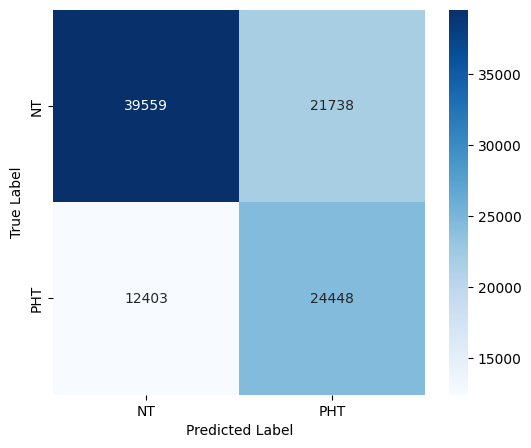

In [45]:
import seaborn as sns
cm = [[39559,  21738],
      [12403,  24448]]
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NT',"PHT"], yticklabels=['NT', 'PHT'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.title('Confusion Matrix')

In [18]:
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
        "dropout":0.5,
    },
    "learning_rate": 1e-4,
    "batch_size": 64,
    "epochs":100,
    "min_epochs":15,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\aaaa",
    "patience":5    
          }

In [40]:
from se_resnet1d import resnet18mini as resnet
model = resnet(num_classes=config["network"]["n_classes"],in_channels=1)

In [ ]:
val_

In [9]:
from torchinfo import summary
summary(model, (16,1, 1250), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
ResNet1D_Small                           [16, 2]                   --
├─Conv1d: 1-1                            [16, 32, 597]             2,048
├─BatchNorm1d: 1-2                       [16, 32, 597]             64
├─ReLU: 1-3                              [16, 32, 597]             --
├─MaxPool1d: 1-4                         [16, 32, 299]             --
├─Sequential: 1-5                        [16, 32, 299]             --
│    └─BasicBlock2: 2-1                  [16, 32, 299]             --
│    │    └─Conv1d: 3-1                  [16, 32, 299]             5,120
│    │    └─BatchNorm1d: 3-2             [16, 32, 299]             64
│    │    └─ReLU: 3-3                    [16, 32, 299]             --
│    │    └─Conv1d: 3-4                  [16, 32, 299]             5,120
│    │    └─BatchNorm1d: 3-5             [16, 32, 299]             64
│    │    └─ReLU: 3-6                    [16, 32, 299]             --
│    └

## train

In [24]:
train_dataset.y.unique(return_counts=True)

(tensor([0, 1]), tensor([ 13327, 298046]))

In [42]:
train_dataset.y.unique(return_counts=True),test_dataset.y.unique(return_counts=True)

((tensor([0, 1]), tensor([502775, 286359])),
 (tensor([0, 1]), tensor([61297, 36851])))

In [41]:
train_model(config)

train_loss_step,███▃▁▄
train_loss_step,0.66054


device: cuda
tensor([0.7848, 1.3779])


Validation loss decreased (0.61199 --> 0.61199).  Saving model ...
Epoch [1/100] Train Loss: 0.6117 Val Loss: 0.6120


EarlyStopping counter: 1 out of 5
the best of loss: 0.61199
Epoch [2/100] Train Loss: 0.5806 Val Loss: 0.6208


KeyboardInterrupt: 

In [14]:
train_model_clf_cv(config)

The output path ..\outputs\resnet\0415_2class_cv_res18mini4 does not exist. Proceeding...


(249952, 1, 1250) (249952,)
torch.Size([249952, 1, 1250]) torch.Size([249952])
torch.Size([62488, 1, 1250]) torch.Size([62488])
device: cuda
ラベル 0: 137792件
ラベル 1: 112160件
ラベル 0: 33988件
ラベル 1: 28500件
tensor([0.9070, 1.1143])


Validation loss decreased (0.47124 --> 0.47124).  Saving model ...
Epoch [1/100] Train Loss: 0.5622 Val Loss: 0.4712


EarlyStopping counter: 1 out of 5
the best of loss: 0.47124
Epoch [2/100] Train Loss: 0.4116 Val Loss: 0.4798


EarlyStopping counter: 2 out of 5
the best of loss: 0.47124
Epoch [3/100] Train Loss: 0.3716 Val Loss: 0.5437


EarlyStopping counter: 3 out of 5
the best of loss: 0.47124
Epoch [4/100] Train Loss: 0.3465 Val Loss: 0.5022


EarlyStopping counter: 4 out of 5
the best of loss: 0.47124
Epoch [5/100] Train Loss: 0.3260 Val Loss: 0.5019


EarlyStopping counter: 5 out of 5
the best of loss: 0.47124
Early Stopping!
(249952, 1, 1250) (249952,)
torch.Size([249952, 1, 1250]) torch.Size([249952])
torch.Size([62488, 1, 1250]) torch.Size([62488])
device: cuda
ラベル 0: 136341件
ラベル 1: 113611件
ラベル 0: 35439件
ラベル 1: 27049件
tensor([0.9166, 1.1000])


Validation loss decreased (0.52318 --> 0.52318).  Saving model ...
Epoch [1/100] Train Loss: 0.5297 Val Loss: 0.5232


Validation loss decreased (0.52318 --> 0.49076).  Saving model ...
Epoch [2/100] Train Loss: 0.4073 Val Loss: 0.4908


Validation loss decreased (0.49076 --> 0.48661).  Saving model ...
Epoch [3/100] Train Loss: 0.3688 Val Loss: 0.4866


EarlyStopping counter: 1 out of 5
the best of loss: 0.48661
Epoch [4/100] Train Loss: 0.3441 Val Loss: 0.4916


EarlyStopping counter: 2 out of 5
the best of loss: 0.48661
Epoch [5/100] Train Loss: 0.3237 Val Loss: 0.5042


EarlyStopping counter: 3 out of 5
the best of loss: 0.48661
Epoch [6/100] Train Loss: 0.3063 Val Loss: 0.5435


EarlyStopping counter: 4 out of 5
the best of loss: 0.48661
Epoch [7/100] Train Loss: 0.2912 Val Loss: 0.5694


EarlyStopping counter: 5 out of 5
the best of loss: 0.48661
Early Stopping!
(249952, 1, 1250) (249952,)
torch.Size([249952, 1, 1250]) torch.Size([249952])
torch.Size([62488, 1, 1250]) torch.Size([62488])
device: cuda
ラベル 0: 137503件
ラベル 1: 112449件
ラベル 0: 34277件
ラベル 1: 28211件
tensor([0.9089, 1.1114])


Validation loss decreased (0.44217 --> 0.44217).  Saving model ...
Epoch [1/100] Train Loss: 0.5597 Val Loss: 0.4422


EarlyStopping counter: 1 out of 5
the best of loss: 0.44217
Epoch [2/100] Train Loss: 0.4080 Val Loss: 0.4524


Validation loss decreased (0.44217 --> 0.43367).  Saving model ...
Epoch [3/100] Train Loss: 0.3678 Val Loss: 0.4337


Validation loss decreased (0.43367 --> 0.41791).  Saving model ...
Epoch [4/100] Train Loss: 0.3401 Val Loss: 0.4179


EarlyStopping counter: 1 out of 5
the best of loss: 0.41791
Epoch [5/100] Train Loss: 0.3192 Val Loss: 0.4394


EarlyStopping counter: 2 out of 5
the best of loss: 0.41791
Epoch [6/100] Train Loss: 0.3003 Val Loss: 0.4503


EarlyStopping counter: 3 out of 5
the best of loss: 0.41791
Epoch [7/100] Train Loss: 0.2832 Val Loss: 0.4629


EarlyStopping counter: 4 out of 5
the best of loss: 0.41791
Epoch [8/100] Train Loss: 0.2679 Val Loss: 0.5139


EarlyStopping counter: 5 out of 5
the best of loss: 0.41791
Early Stopping!
(249952, 1, 1250) (249952,)
torch.Size([249952, 1, 1250]) torch.Size([249952])
torch.Size([62488, 1, 1250]) torch.Size([62488])
device: cuda
ラベル 0: 137339件
ラベル 1: 112613件
ラベル 0: 34441件
ラベル 1: 28047件
tensor([0.9100, 1.1098])


Validation loss decreased (0.48777 --> 0.48777).  Saving model ...
Epoch [1/100] Train Loss: 0.5490 Val Loss: 0.4878


EarlyStopping counter: 1 out of 5
the best of loss: 0.48777
Epoch [2/100] Train Loss: 0.4061 Val Loss: 0.5744


EarlyStopping counter: 2 out of 5
the best of loss: 0.48777
Epoch [3/100] Train Loss: 0.3652 Val Loss: 0.5021


EarlyStopping counter: 3 out of 5
the best of loss: 0.48777
Epoch [4/100] Train Loss: 0.3384 Val Loss: 0.4941


EarlyStopping counter: 4 out of 5
the best of loss: 0.48777
Epoch [5/100] Train Loss: 0.3153 Val Loss: 0.5512


EarlyStopping counter: 5 out of 5
the best of loss: 0.48777
Early Stopping!
(249952, 1, 1250) (249952,)
torch.Size([249952, 1, 1250]) torch.Size([249952])
torch.Size([62488, 1, 1250]) torch.Size([62488])
device: cuda
ラベル 0: 138145件
ラベル 1: 111807件
ラベル 0: 33635件
ラベル 1: 28853件
tensor([0.9047, 1.1178])


Validation loss decreased (0.54128 --> 0.54128).  Saving model ...
Epoch [1/100] Train Loss: 0.5143 Val Loss: 0.5413


Validation loss decreased (0.54128 --> 0.49782).  Saving model ...
Epoch [2/100] Train Loss: 0.3992 Val Loss: 0.4978


EarlyStopping counter: 1 out of 5
the best of loss: 0.49782
Epoch [3/100] Train Loss: 0.3631 Val Loss: 0.5343


EarlyStopping counter: 2 out of 5
the best of loss: 0.49782
Epoch [4/100] Train Loss: 0.3362 Val Loss: 0.5547


EarlyStopping counter: 3 out of 5
the best of loss: 0.49782
Epoch [5/100] Train Loss: 0.3165 Val Loss: 0.5647


EarlyStopping counter: 4 out of 5
the best of loss: 0.49782
Epoch [6/100] Train Loss: 0.2984 Val Loss: 0.5369


EarlyStopping counter: 5 out of 5
the best of loss: 0.49782
Early Stopping!


accuracy,▄▅▃▄▅▆▂▅▅▅▅▄▄▄▆▆▇█▇▇▇▆▇▄▁▆▆▄▄▂▄▃▃▃▄▄
epoch,▁▂▃▄▅▅▁▂▃▄▅▅▆▇▁▂▃▄▅▅▆▇█▁▂▃▄▅▅▁▂▃▄▅▅▆
f1_macro,▄▅▂▄▅▆▂▅▅▅▅▃▄▄▆▆▇█▇▇▇▆▇▄▁▆▆▅▄▁▄▄▄▄▄▄
lr,▂▆██▇▇▆▂███▇▇▆▅▄▄███▇▇▆▅▄▁▅██▇▇▆▃▇██▇▇▆▅
test_loss,▃▄▇▅▅▄▆▄▄▄▅▇██▂▃▂▁▂▂▃▅▅▄█▅▄▇▇▇▅▆▇█▆█
test_loss_step,▃▃▁▂▁▂▂▂█▂▂▂▂▁▇▁▆▁▃▂▃▁▄▁▁▂▂▂▂▂▃▃▃▃▂▂▂▂▁▂
train_loss,█▅▄▃▃▂▇▄▄▃▃▂▂▁█▄▄▃▂▂▂▁▁█▄▄▃▂▂▇▄▃▃▂▂▂
train_loss_step,▆▄▂▂▂▂▂▅▃▃▃▂▂▃▃▂▆▄▂▄▄▃▃▁▁█▅▃▂▁▃▁▅▂▁▄▃▅▃▄
accuracy,0.77149
epoch,7
f1_macro,0.769


## Regression

### cv

In [ ]:
from torchtune.modules import get_cosine_schedule_with_warmup
def train_model_regr_cv(model,config,fold=5):
    output_warning(config)
    data_dir = '../../data/processed/BP_npy/PulseDB'
    cv_idx_path = r"../../data/processed/BP_npy/PulseDB/cv_5fold.pkl"
    with open(cv_idx_path, "rb") as f:
        cv_idx = pickle.load(f)
    # Initialize Weights & Biases (wandb)
    wandb.init(project="regression-training", config=config)
    config = wandb.config
    
    for f in range(fold):
        
        train_dataset = BPDataset_Regr(data_dir,cv=cv_idx[0][f],train=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = BPDataset_Regr(data_dir,cv=cv_idx[1][f],train=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("device:",device)

        # Model, Loss, and Optimizer
        criterion = nn.L1Loss()
        # criterion = nn.CrossEntropyLoss()
        # mae = nn.L1Loss()  # Mean Squared Error Loss for regression
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        total_step_size = len(train_loader) * config.epochs
        warmup_steps = int(total_step_size * 0.1)  # 10% of total steps
        lr_scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_step_size)
        earlystopping = EarlyStopping(f"{config.output_path}/best_fold{f}.pth",config.patience,verbose=True)
        model.to(device)

        wandb.watch(model, log_freq=config.log_interval)
        for epoch in range(config.epochs):
            model.train()
            running_loss = 0.0
            # running_loss_mae = 0.0
            # Training phase with progress bar
            train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{config.epochs} - Training", leave=False)
            for batch_idx, (x,sbp,dbp) in enumerate(train_loader_tqdm):
                x,sbp,dbp = x.to(device), sbp.to(device),dbp.to(device)
                # print(gt.shape,cond.shape)
                optimizer.zero_grad()
                outputs = model(x)
                # print(outputs.device,y.device)
                loss_sbp = criterion(outputs[:,0], sbp) 
                loss_dbp = criterion(outputs[:,1], dbp)
                loss = loss_sbp + loss_dbp
                # loss_mae = mae(outputs, gt)
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                if batch_idx % config.log_interval == 0:
                    wandb.log({"train_loss_step": loss.item()})
                # if batch_idx  == 0:
                    # wandb.log({"train/loss": log_img(gt,outputs)})
                running_loss += loss.item()
                # running_loss_mae += loss_mae.item()
                train_loader_tqdm.set_postfix(loss=running_loss/(batch_idx+1))

            train_loss = running_loss / len(train_loader)
            # train_loss_mae = running_loss_mae / len(train_loader)

            # Validation phase with progress bar
            model.eval()
            val_loss = 0.0
            all_y_true = []
            all_y_pred = []
            val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{config.epochs} - Validation", leave=False)
            with torch.no_grad():
                for batch_idx, (x,sbp,dbp) in enumerate(val_loader_tqdm):

                    x,sbp,dbp = x.to(device), sbp.to(device),dbp.to(device)
                    outputs = model(x)
                    # print(outputs.device,y.device)
                    loss_sbp = criterion(outputs[:,0], sbp) 
                    loss_dbp = criterion(outputs[:,1], dbp)
                    loss = loss_sbp + loss_dbp
                    # loss_mae = mae(outputs, gt)
                    if batch_idx % config.log_interval == 0:
                        wandb.log({"test_loss_step": loss.item()})
                    # if batch_idx  == 0:
                    #     wandb.log({"val/loss": log_img(gt,outputs)})
                    val_loss += loss.item()
                    # val_loss_mae += loss_mae.item()
                    all_y_true.extend(np.array([sbp.cpu().numpy(),dbp.cpu().numpy()]))
                    all_y_pred.extend(np.array([outputs[:,0].cpu().numpy(),outputs[:,1].cpu().numpy()]))
            all_y_true = np.concatenate(all_y_true,axis=0).reshape(-1,2)
            all_y_pred = np.concatenate(all_y_pred,axis=0).reshape(-1,2)
            # print(all_y_true.shape,all_y_pred.shape)
            # accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred,classes=config["network"]["n_classes"])
            error = (all_y_true - all_y_pred)
            mse = np.mean(error**2,axis=0)
            rmse = np.sqrt(mse)
            std = np.std(error,axis=0)
            val_loss = val_loss / len(val_loader)
            # WandBでのログ記録例
            wandb.log({
                "train_loss": train_loss,
                "test_loss": val_loss,
                "mse_sbp": mse[0],
                "rmse_sbp": rmse[0],
                "std_sbp": std[0],
                "mse_dbp": mse[1],
                "rmse_dbp": rmse[1],
                "std_dbp": std[1],
                # "conf_mat": wandb.plot.confusion_matrix(y_true=all_y_true, preds=all_y_pred, class_names=["0","1","2","3"]),
                "epoch": epoch + 1
            })
            # val_loss /= len(val_loader)
            # val_loss_mae /= len(val_loader)
            earlystopping(val_loss,model)
            if earlystopping.early_stop:
                print("Early Stopping!")
                break
            # Log metrics to wandb
            # wandb.log({
            #     "epoch": epoch + 1,
            #     "train/loss_epoch": train_loss,
            #     "train/mae": train_loss_mae,
            #     "val/loss_epoch": val_loss,
            #     "val/mae": val_loss_mae
            # })

            print(f"Epoch [{epoch + 1}/{config.epochs}]"
                f" Train Loss: {train_loss:.4f}"
                f" Val Loss: {val_loss:.4f}")



ImportError: 
        torchao not installed.
        Please follow the instructions at https://pytorch.org/torchtune/main/install.html#pre-requisites
        to install torchao.
        

### test only

In [ ]:
def train_model_regr(config):
    
    # Initialize Weights & Biases (wandb)
    wandb.init(project="regression-training", config=config)
    config = wandb.config
    
    # Dataset and DataLoader
    # train_dataset = train_dataset(data_root=r"..\data\processed\BP_npy\250107_1152\p00")
    # train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    train_loader = train_dataloader
    # val_dataset = test_dataset(data_len=-1,data_root=r"..\data\processed\BP_npy\250107_1152\p00")
    # val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    val_loader = test_dataloader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device:",device)

        
    # Model, Loss, and Optimizer
    model = ResNet1D(**config["network"])
    criterion = nn.L1Loss()
    # criterion = nn.CrossEntropyLoss()
    # mae = nn.L1Loss()  # Mean Squared Error Loss for regression
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    earlystopping = EarlyStopping(f"{config.output_path}/best.pth",config.patience,verbose=True)
    model.to(device)

    wandb.watch(model, log_freq=config.log_interval)
    for epoch in range(config.epochs):
        model.train()
        running_loss = 0.0
        # running_loss_mae = 0.0
        # Training phase with progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{config.epochs} - Training", leave=False)
        for batch_idx, (x,sbp,dbp) in enumerate(train_loader_tqdm):
            x,sbp,dbp = x.to(device), sbp.to(device),dbp.to(device)
            # print(gt.shape,cond.shape)
            optimizer.zero_grad()
            outputs = model(x)
            # print(outputs.device,y.device)
            loss_sbp = criterion(outputs[:,0], sbp) 
            loss_dbp = criterion(outputs[:,1], dbp)
            loss = loss_sbp + loss_dbp
            # loss_mae = mae(outputs, gt)
            loss.backward()
            optimizer.step()
            if batch_idx % config.log_interval == 0:
                wandb.log({"train_loss_step": loss.item()})
            # if batch_idx  == 0:
                # wandb.log({"train/loss": log_img(gt,outputs)})
            running_loss += loss.item()
            # running_loss_mae += loss_mae.item()
            train_loader_tqdm.set_postfix(loss=running_loss/(batch_idx+1))

        train_loss = running_loss / len(train_loader)
        # train_loss_mae = running_loss_mae / len(train_loader)

        # Validation phase with progress bar
        model.eval()
        val_loss = 0.0
        all_y_true = []
        all_y_pred = []
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{config.epochs} - Validation", leave=False)
        with torch.no_grad():
            for batch_idx, (x,sbp,dbp) in enumerate(val_loader_tqdm):

                x,sbp,dbp = x.to(device), sbp.to(device),dbp.to(device)
                outputs = model(x)
                # print(outputs.device,y.device)
                loss_sbp = criterion(outputs[:,0], sbp) 
                loss_dbp = criterion(outputs[:,1], dbp)
                loss = loss_sbp + loss_dbp
                # loss_mae = mae(outputs, gt)
                if batch_idx % config.log_interval == 0:
                    wandb.log({"test_loss_step": loss.item()})
                # if batch_idx  == 0:
                #     wandb.log({"val/loss": log_img(gt,outputs)})
                val_loss += loss.item()
                # val_loss_mae += loss_mae.item()
                all_y_true.extend(np.array([sbp.cpu().numpy(),dbp.cpu().numpy()]))
                all_y_pred.extend(np.array([outputs[:,0].cpu().numpy(),outputs[:,1].cpu().numpy()]))
        all_y_true = np.concatenate(all_y_true,axis=0).reshape(-1,2)
        all_y_pred = np.concatenate(all_y_pred,axis=0).reshape(-1,2)
        # print(all_y_true.shape,all_y_pred.shape)
        # accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred,classes=config["network"]["n_classes"])
        error = (all_y_true - all_y_pred)
        mse = np.mean(error**2,axis=0)
        rmse = np.sqrt(mse)
        std = np.std(error,axis=0)
        val_loss = val_loss / len(val_loader)
        # WandBでのログ記録例
        wandb.log({
            "train_loss": train_loss,
            "test_loss": val_loss,
            "mse_sbp": mse[0],
            "rmse_sbp": rmse[0],
            "std_sbp": std[0],
            "mse_dbp": mse[1],
            "rmse_dbp": rmse[1],
            "std_dbp": std[1],
            # "conf_mat": wandb.plot.confusion_matrix(y_true=all_y_true, preds=all_y_pred, class_names=["0","1","2","3"]),
            "epoch": epoch + 1
        })
        # val_loss /= len(val_loader)
        # val_loss_mae /= len(val_loader)
        earlystopping(val_loss,model)
        if earlystopping.early_stop:
            print("Early Stopping!")
            break
        # Log metrics to wandb
        # wandb.log({
        #     "epoch": epoch + 1,
        #     "train/loss_epoch": train_loss,
        #     "train/mae": train_loss_mae,
        #     "val/loss_epoch": val_loss,
        #     "val/mae": val_loss_mae
        # })

        print(f"Epoch [{epoch + 1}/{config.epochs}]"
              f" Train Loss: {train_loss:.4f}"
              f" Val Loss: {val_loss:.4f}")


In [ ]:
# データセットとDataLoaderの作成
data_dir = '../../data/processed/BP_npy/PulseDB'
batch_size = 32

# train_dataset = BPDataset_Regr(data_dir,train=True)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = BPDataset_Regr(data_dir,train=False)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# トレーニングデータの確認
x, y1,y2 = train_dataset[0]
print("Training data:")
print(f"x shape: {x.shape}, x dtype: {x.dtype}")
print(f"y shape: {y1.shape}, y dtype: {y1.dtype}")
# print(f"Unique labels in training: {torch.unique(train_dataset.y)}")

# テストデータの確認
x, y1,y2 = test_dataset[0]
print("\nTest data:")
print(f"x shape: {x.shape}, x dtype: {x.dtype}")
print(f"y shape: {y1.shape}, y dtype: {y1.dtype}")

NameError: name 'train_dataset' is not defined

In [ ]:
a,i,u=train_dataset[0]
i,u

(tensor(0.4681), tensor(0.3178))

In [ ]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 24amj35 (bsa_mh). Use `wandb login --relogin` to force relogin


True

In [ ]:
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
    },
    "learning_rate": 1e-3,
    "batch_size": batch_size,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0308_regr",
    "patience":10    
          }

### func

In [ ]:
cv_idx_path = r"../../data/processed/BP_npy/PulseDB/cv_5fold.pkl"
with open(cv_idx_path, "rb") as f:
    cv_idx = pickle.load(f)
print(len(cv_idx[0]))

5


In [ ]:
model = ResNet1D(**config["network"])

In [ ]:
train_model_regr_cv(model,config)

The output path ..\outputs\resnet\0310_trans does not exist. Proceeding...


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# best_ckpt = ".\\"+config["output_path"]+"\\best.pth"
# model = ResNet1D(config, "not").to(device)
# model.load_state_dict(torch.load(best_ckpt))

## Transfer Learning


In [ ]:
from resnet1d import ResNet1D
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
    },
    "learning_rate": 1e-3,
    "batch_size": 32,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0310_trans",
    "patience":10    
          }
model = ResNet1D(**config["network"])

In [ ]:
model.load_state_dict(torch.load('..\\outputs\\resnet\\0228\\best.pth'))

<All keys matched successfully>

freeze


In [ ]:

layers_to_freeze = [model.first_block_conv,
                    model.first_block_bn,
                    model.first_block_relu,
                    model.basicblock_list[0],
                    model.basicblock_list[1]
                    ]
for layer in layers_to_freeze:
    for param in layer.parameters():
        param.requires_grad = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
train_model_regr_cv(model,config)

The output path ..\outputs\resnet\0310_trans does not exist. Proceeding...


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 24amj35 (bsa_mh). Use `wandb login --relogin` to force relogin


NameError: name 'data_dir' is not defined